# OBJECT DETETCION USING VIDEO API

In [2]:
from google.cloud import videointelligence

import time

gcs_uri = "https://storage.cloud.google.com/live2eat-bootcamp/Dish%20Videos/Bak%20Chor%20Mee.mp4"
output_uri = "gs://live2eat-bootcamp/video_analysis_output - {}.json".format(time.time())

credentials = service_account.Credentials.from_service_account_info(
    st.secrets['gcp_service_account'])

   video_client = videointelligence.VideoIntelligenceServiceClient(
        credentials=credentials)

video_client = videointelligence.VideoIntelligenceServiceClient.from_service_account_file(
    "lewagon-livetoeat-cdabf6bc01ed.json")

FileNotFoundError: [Errno 2] No such file or directory: 'lewagon-livetoeat-cdabf6bc01ed.json'

In [36]:
from typing import Optional, Sequence

from google.cloud import videointelligence as vi


def track_objects(
    gcs_uri: str, segments: Optional[Sequence[vi.VideoSegment]] = None
) -> vi.VideoAnnotationResults:
    video_client = vi.VideoIntelligenceServiceClient()
    features = [vi.Feature.OBJECT_TRACKING]
    context = vi.VideoContext(segments=segments)
    request = vi.AnnotateVideoRequest(
        input_uri=gcs_uri,
        features=features,
        video_context=context,
    )

    print(f'Processing video "{gcs_uri}"...')
    operation = video_client.annotate_video(request)

    return operation.result().annotation_results[0]  # Single video

In [44]:
from datetime import timedelta

segment = vi.VideoSegment(
    start_time_offset=timedelta(seconds=1),
    end_time_offset=timedelta(seconds=240),
)

results = track_objects(gcs_uri, [segment])

Processing video "gs://videozzz/Food.mp4"...


PermissionDenied: 403 The caller does not have permission

In [16]:
def print_object_frames(
    results: vi.VideoAnnotationResults, entity_id: str, min_confidence: float = 0.7
):
    def keep_annotation(annotation: vi.ObjectTrackingAnnotation) -> bool:
        return all(
            [
                annotation.entity.entity_id == entity_id,
                min_confidence <= annotation.confidence,
            ]
        )

    annotations = results.object_annotations
    annotations = [a for a in annotations if keep_annotation(a)]
    for annotation in annotations:
        description = annotation.entity.description
        confidence = annotation.confidence
        print(
            f" {description},"
            f" confidence: {confidence:.0%},"
            f" frames: {len(annotation.frames)} ".center(80, "-")
        )
        for frame in annotation.frames:
            t = frame.time_offset.total_seconds()
            box = frame.normalized_bounding_box
            print(
                f"{t:>7.3f}",
                f"({box.left:.5f}, {box.top:.5f})",
                f"({box.right:.5f}, {box.bottom:.5f})",
                sep=" | ",
            )

In [8]:
food_entity_id = '/m/02wbm'
print_object_frames(results, food_entity_id)

NameError: name 'results' is not defined

# FFMPEG

In [ ]:
# pip install ffmpeg-python
# git clone git@github.com:kkroening/ffmpeg-python.git
# pip install -e ./ffmpeg-python

### Taking snapshots at set intervals (Not useful)

In [ ]:
import ffmpeg

YOUR_FILE = 'sample-mov-file.mov'
probe = ffmpeg.probe(YOUR_FILE)
time = float(probe['streams'][0]['duration']) // 2
width = probe['streams'][0]['width']

# Set how many spots you want to extract a video from. 
parts = 7

intervals = time // parts
intervals = int(intervals)
interval_list = [(i * intervals, (i + 1) * intervals) for i in range(parts)]
i = 0

for item in interval_list:
    (
        ffmpeg
        .input(YOUR_FILE, ss=item[1])
        .filter('scale', width, -1)
        .output('Image' + str(i) + '.jpg', vframes=1)
        .run()
    )
    i += 1

### Reading frame number as JPEG

In [18]:
#!/usr/bin/env python
from __future__ import unicode_literals
import argparse
import ffmpeg
import sys


parser = argparse.ArgumentParser(
    description='Read individual video frame into memory as jpeg and write to stdout')
parser.add_argument('in_filename', help='Input filename')
parser.add_argument('frame_num', help='Frame number')


def read_frame_as_jpeg(in_filename, frame_num):
    out, err = (
        ffmpeg
        .input(in_filename)
        .filter('select', 'gte(n,{})'.format(frame_num))
        .output('pipe:', vframes=1, format='image2', vcodec='mjpeg')
        .run(capture_stdout=True)
    )
    return out


if __name__ == '__main__':
    args = parser.parse_args()
    out = read_frame_as_jpeg(args.in_filename, args.frame_num)
    sys.stdout.buffer.write(out)

usage: ipykernel_launcher.py [-h] in_filename frame_num
ipykernel_launcher.py: error: the following arguments are required: in_filename, frame_num


SystemExit: 2

/home/menghuang/.pyenv/versions/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# CV2

In [10]:
# #pip install opencv-python
# #Change frame_count
# import cv2
 
# cap = cv2.VideoCapture(gcs_uri)
 
# success, image = cap.read()
# frame_count = 0
# while success:
#     cv2.imwrite(f"extracted_images/frame_{frame_count}.jpg", image)             
#     success, image = cap.read()
#     frame_count += 1
 
# cap.release()

In [45]:
import cv2
import os
  
# Read the video from specified path
cam = cv2.VideoCapture(gcs_uri)
  
try:
      
    # creating a folder named data
    if not os.path.exists('data'):
        os.makedirs('data')
  
# if not created then raise error
except OSError:
    print ('Error: Creating directory of data')
  
# frame
currentframe = 0
  
while(True):
      
    # reading from frame (replace with print_object_frames(results, food_entity_id))
    ret,frame = cam.read()
  
    if ret:
        # if video is still left continue creating images
        name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name)
  
        # writing the extracted images
        cv2.imwrite(name, frame)
  
        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
    else:
        break
  
# Release all space and windows once done
cam.release()

# Set the testing path as Data folder storing the snapshots

In [81]:
import cv2
import os

cam = cv2.VideoCapture('/home/shyann/code/seshyblack/live2eat/raw_data/Bak Chor Mee.mp4')


In [82]:
fps = cam.get(cv2.CAP_PROP_FPS)
frame_count = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count/fps
duration

113.93333333333334

In [88]:
start_time = 110000
X_start = cam.set(cv2.CAP_PROP_POS_MSEC, start_time)
X_start = cam.read()
start_frame = int(cam.get(cv2.CAP_PROP_POS_FRAMES))
start_frame

3301

In [89]:
end_time = 113000
X_end = cam.set(cv2.CAP_PROP_POS_MSEC, end_time)
X_end = cam.read()
end_frame = int(cam.get(cv2.CAP_PROP_POS_FRAMES))
end_frame

3391

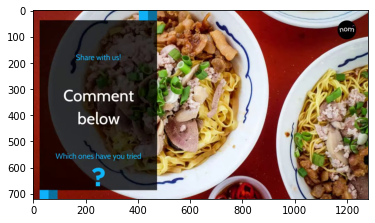

In [85]:
import matplotlib.pyplot as plt

plt.imshow(X_start[1][:,:,::-1])

In [90]:
try:
    
    # creating a folder named data
    if not os.path.exists('data'):
        os.makedirs('data')
  
# if not created then raise error
except OSError:
    print ('Error: Creating directory of data')
  
  
# frame
currentframe = int(start_frame)

  
while(True):
      
    # reading from frame
    ret,frame = cam.read()
  
    if ret:
        
        for frame_no in range(start_frame, end_frame):
        # if video is still left continue creating images
            name = './data/frame' + str(currentframe) + '.jpg'
            print ('Creating...' + name)
    
            # writing the extracted images
            cv2.imwrite(name, frame)
    
            # increasing counter so that it will
            # show how many frames are created
            currentframe += 1
    else:
        break
  
# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

TypeError: 'float' object is not callable